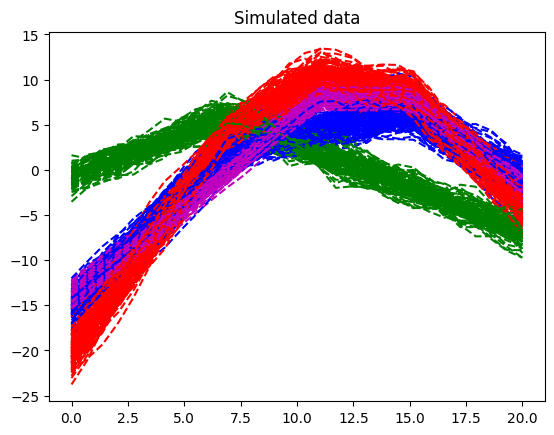

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

# Ignore convergence warnings
import warnings
warnings.filterwarnings("ignore")

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.8 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sample from the Gaussian process distribution
nb_of_samples = 30  # Number of points in each function
# Independent variable samples
t = np.expand_dims(np.linspace(0, 20, nb_of_samples), 1)
Σ = exponentiated_quadratic(t/0.5, t/12)  # Kernel of data points
Σ2 = exponentiated_quadratic(t, t/12)  # Kernel of data points
Σ3 = exponentiated_quadratic(t, t*2/3)  # Kernel of data points


# Declare the mean curve
mean_curve = np.zeros((3, len(t)))
# Mean curve with white noise
mean_curve[0] = np.reshape(6 - np.abs(t - 11), (nb_of_samples))
mean_curve[1] = np.reshape(6 - np.abs(t - 7), (nb_of_samples))
mean_curve[2] = np.reshape(6 - np.abs(t - 15), (nb_of_samples))


mixture_k = [0.3, 0.3, 0.2, 0.2]
n = 500
Y = np.zeros((n, len(t)))
simulation_label = np.zeros(n)

for i in range(n):
    # generate a random number between 0 and 1
    r = np.random.rand()
    # find the index of the mixture component
    if r < mixture_k[0]:
        # draw for the first component
        ys = -5 + np.reshape(t/2, (nb_of_samples)) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ2, size=1) + np.random.multivariate_normal(mean=mean_curve[1], cov=Σ3, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='b')
        # Remember the label of the component
        simulation_label[i] = 0
    elif r < mixture_k[0] + mixture_k[1]:
        # draw for the first component
        ys = -5 + np.reshape(t/2, (nb_of_samples)) + np.random.multivariate_normal(mean=mean_curve[0], cov=Σ, size=1) + np.random.multivariate_normal(mean=mean_curve[1], cov=Σ2, size=1) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ3, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.5)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='r')
        # Remember the label of the component
        simulation_label[i] = 1
    elif r < mixture_k[0] + mixture_k[1] + mixture_k[2]:
        # draw for the first component
        ys = np.random.multivariate_normal(mean=mean_curve[1], cov=Σ3, size=1)+ np.random.normal(0, 0.08, len(t))*np.sqrt(10)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='g')
        # Remember the label of the component
        simulation_label[i] = 2
    else:
        # draw for the first component
        ys = np.random.multivariate_normal(mean=mean_curve[0], cov=Σ, size=1) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.5)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='m')
        # Remember the label of the component
        simulation_label[i] = 3

plt.title('Simulated data')
plt.show()

Percentage of variation explained by each eigen dimensions:  [0.83478965 0.09238964 0.02930069 0.02149391 0.00576663 0.004682
 0.00406332 0.0030629  0.00262804 0.00182322]


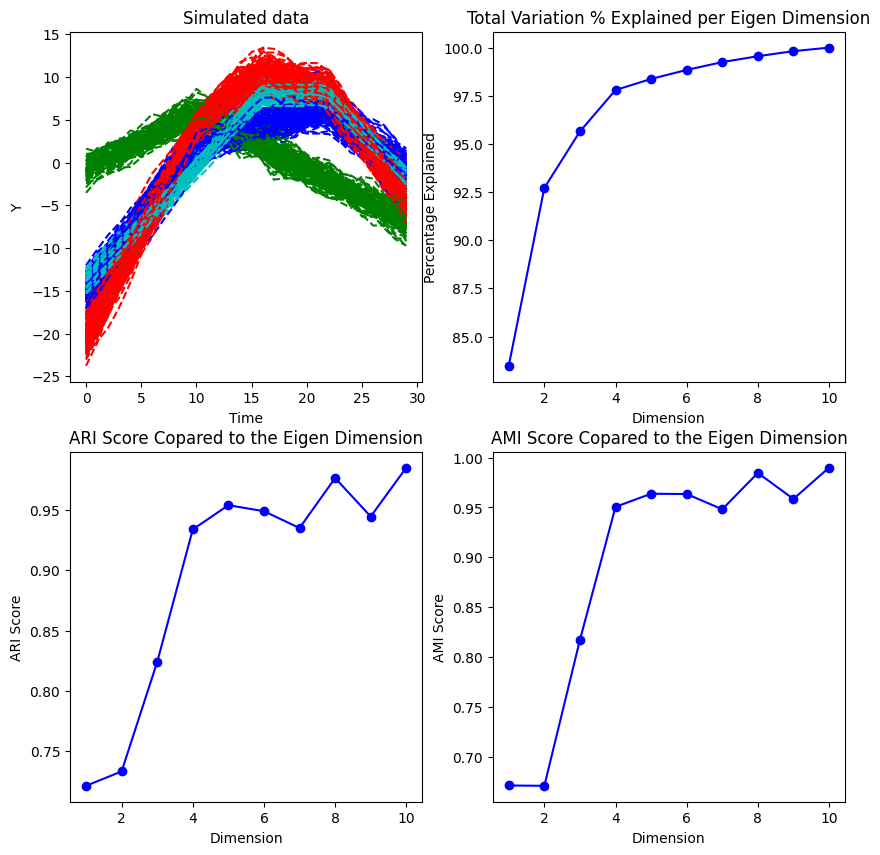

In [7]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, Y, 150, simulation_label, 4)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, simulation_label, Y)

In [8]:
print(variance)

[0.83478965 0.09238964 0.02930069 0.02149391 0.00576663 0.004682
 0.00406332 0.0030629  0.00262804 0.00182322]


In [13]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate

# Second function which takes eigen values and clusters K and outputs probabilities and spectral clustering result
def functional_data_clustering (eigen_values, K, variance):
    # Fit a Gaussian mixture model with K components
    membership_matrices = []
    n = len(eigen_values[0])
    for i in range(n):
        gmm = GaussianMixture(n_components=K, covariance_type='full')
        gmm.fit(eigen_values[:, i].reshape(-1, 1))
        labels = gmm.predict(eigen_values[:, i].reshape(-1, 1))
        #Create the membership probabilities for each component
        probability = gmm.predict_proba(eigen_values[:, i].reshape(-1,1))
        membership_matrices.append(probability)

    # Create binary membership matrices for each element in probabilities
    # for i in range(V):
    #     for j in range(n):
    #         for k in range(4):
    #             #Binary membership matrix based on max probability
    #             if probabilities[i][j][k] == max(probabilities[i][j]):
    #                 probabilities[i][j][k] = 1
    #             else:
    #                 probabilities[i][j][k] = 0

        # Multiply each matrix by the variance
    for i in range(n):
        membership_matrices[i] = np.multiply(membership_matrices[i], variance[i])

    # Affinity matrix A, which is the sum of the V cluster membership matrix M_v*M_v^T
    matrix_multiplication = []
    for i in range(n):
        matrix_multiplication.append(np.matmul(membership_matrices[i], membership_matrices[i].T))
    affinity_matrix = sum(matrix_multiplication)
    


    # Apply spectral clustering
    sc = SpectralClustering(n_clusters=K, affinity='precomputed', assign_labels='discretize')
    sc.fit(affinity_matrix)
    labels = sc.labels_

    return membership_matrices, labels

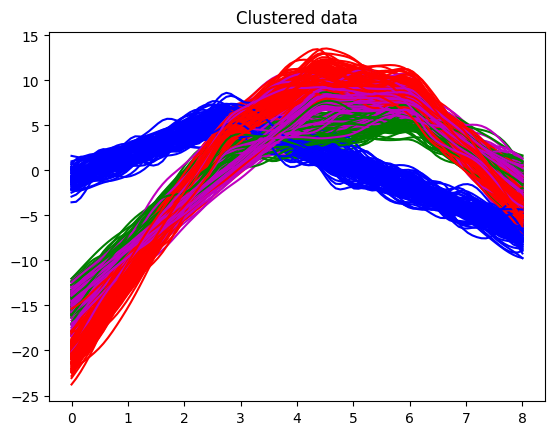

AMI score:
0.7318907118888254
ARI score:
0.6909384149711613


In [14]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, 10, 100)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 4, variance)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

# Get the AMI score
print("AMI score:")
print(adjusted_mutual_info_score(simulation_label, labels))

# Get the ARM scoree
print("ARI score:")
print(adjusted_rand_score(simulation_label, labels))